# A2 Bias in Data

Notebook to identify potential sources of bias in a corpus of human-annotated data, and describe some implications of those biases. The 'Toxicity' and 'Personal Attacks' labelled datasets from Wikipedia are used for exploration.

Import the required libraries

In [9]:
import os
import numpy as np
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

## Download the Data from Figshare

In [ ]:
files = dict()
files['attack_annotated_comments'] = 'https://ndownloader.figshare.com/files/7554634' 
files['attack_annotations'] = 'https://ndownloader.figshare.com/files/7554637' 
files['attack_worker_demographics'] = 'https://ndownloader.figshare.com/files/7640752'

files['toxicity_annotated_comments'] = 'https://ndownloader.figshare.com/files/7394542' 
files['toxicity_annotations'] = 'https://ndownloader.figshare.com/files/7394539' 
files['toxicity_worker_demographics'] = 'https://ndownloader.figshare.com/files/7640581'

def download_file(url, fname):
    """File to download the required data from url 
       and store it in fname
    """
    urllib.request.urlretrieve(url, fname)

Download all the required files and store them in the data folder (takes 2-5 min)

In [ ]:
for key, value in files.items():
    download_file(value, 'data/'+ key + '.tsv')

## Analysis 1: How well does the labeler demograchic distribution match the true population?

If the labeler demographic is highly skewed, this leads to the representation of only some sections of the society and is a potential source of bias.

### Data Processing

In [2]:
## read in the files for personal attack dataset
att_comments = pd.read_csv('data/attack_annotated_comments.tsv', sep = '\t', index_col = 0)
att_annotations = pd.read_csv('data/attack_annotations.tsv',  sep = '\t')
att_demographic = pd.read_csv('data/attack_worker_demographics.tsv',  sep = '\t')


Remove newline and tab tokens


In [3]:
att_comments['comment'] = att_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
att_comments['comment'] = att_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [4]:
total_sample = len(att_demographic) #total number of labellers (unique)

#create age demographic distribution of the sample
age_demo = att_demographic.groupby('age_group',as_index=False).count()
age_demo['worker_id'] = age_demo['worker_id']*100/total_sample

#create gender demographic distribution of the sample
gend_demo = att_demographic.groupby('gender',as_index=False).count()
gend_demo['worker_id'] = gend_demo['worker_id']*100/total_sample

Read in data about the population distribution in the US for the year 2016 [1] 


<b> Note: </b>
Ideally, the total population should consist of the English-speaking population of the world because English Wikipedia is used by users all over the world but unfortunately statistics on english-speaking world population and gender, age breakdown was not available. This analysis uses US total population as a comparison measure to get a rough picture of any extreme under-representation.
    
Year 2016 was chosen because the labelling was performed in 2016 and I wish to compare if the labeler sample is representative of the 2016 population at least as a starting point

In [5]:
#read in population data for 2016
age_gender = pd.read_csv('data/2016_population_data.csv')
population = pd.read_csv('data/2016_total_population.csv')

population['Population'] = population['Population'].str.replace(",", "")
total_pop = population['Population'].astype(int).sum()

#convert % strings to floats
age_gender['Male % of Population']=age_gender['Male % of Population'].str.replace("%", "").astype(float)
age_gender['Female % of Population']=age_gender['Female % of Population'].str.replace("%", "").astype(float)
age_gender['Male'] = age_gender['Male % of Population']*total_pop/100 #percentage of total population
age_gender['Female'] = age_gender['Female % of Population']*total_pop/100

age_gender['Total'] = age_gender['Male'] + age_gender['Female'] #calculate total population by age

    Create function to bin ages in population dataset similar to sample personal attack dataset above

In [6]:
def age_binning(x):
    """Function to take in an age value and
       bin it into one of the following 5 catgories
    """
    if x < 18:
        return 'Under 18'
    elif x < 30:
        return '18-30'
    elif x < 45:
        return '30-45'
    elif x<60:
        return '45-60'
    else:
        return 'Over 60'
    
##bin the ages to be consistent with age group
age_gender['Age'] = age_gender['Age'].str.replace("+", "").astype(int) #convert age to int
age_gender['age_bin'] = age_gender['Age'].apply(lambda x: age_binning(x))

### Gender Distribution

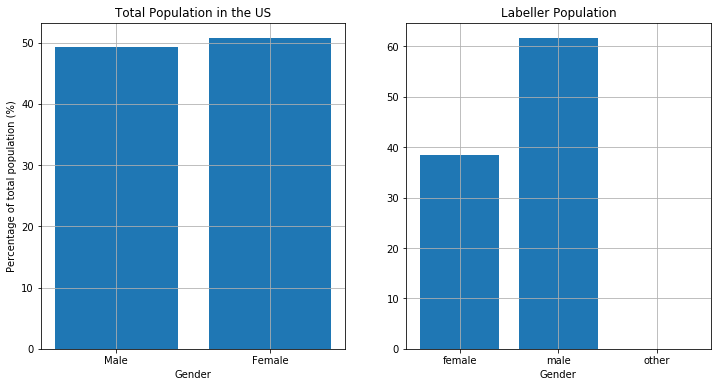

In [8]:
gend_dist = [age_gender['Male'].sum()*100/total_pop,age_gender['Female'].sum()*100/total_pop] #percentage of total population

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax1.bar(['Male','Female'],gend_dist)
ax1.set_ylabel('Percentage of total population (%)')
ax1.set_xlabel('Gender')
ax1.set_title('Total Population in the US')
ax1.grid()

ax2.bar(gend_demo['gender'],gend_demo['worker_id']) #sample distribution
ax2.set_xlabel('Gender')
ax2.set_title('Labeller Population')
ax2.grid()
plt.savefig('images/gender_dist.png') #save to file

<b> The personal attack dataset labeller demographic shows skew in the gender distribution of the labellers compared to the population. About 62% the labellers are male but the true population has a more equal share of male and female. </b> Also since the English speaking population gender distribution is not available, we cannot tell if this skew is very significant.

There is no information about if the labeller population comprised of members of the LGBTQ community (the other category only consists of 1 person). However there is a much larger proportion of LGBTQ people in the true population estimated by https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5508189/

### Age distribution 

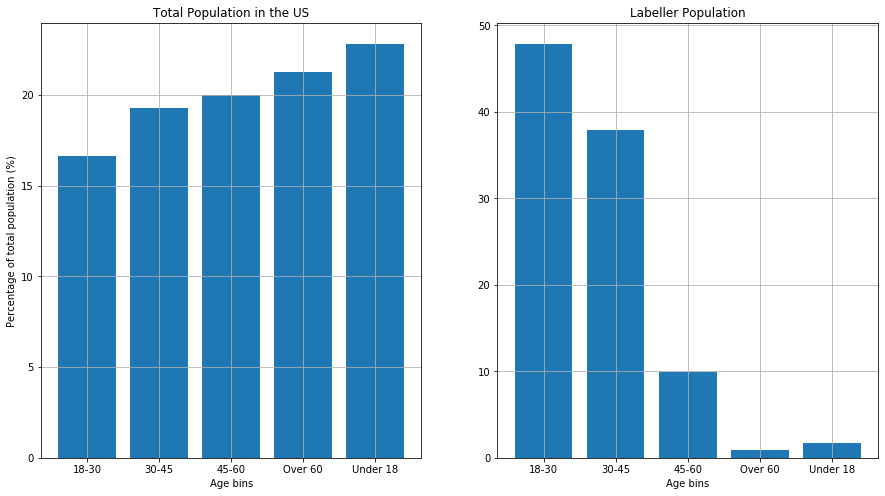

In [7]:
age_dist = age_gender.groupby('age_bin', as_index=False).sum()
age_dist['Total Percentage']= age_dist['Total']*100/total_pop #percentage of total population
#Plot the age distribution of the population vs the labeller sample

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

ax1.bar(age_dist['age_bin'],age_dist['Total Percentage'])
ax1.set_ylabel('Percentage of total population (%)')
ax1.set_xlabel('Age bins')
ax1.set_title('Total Population in the US')
ax1.grid()

ax2.bar(age_demo['age_group'],age_demo['worker_id']) #sample distribution
ax2.set_xlabel('Age bins')
ax2.set_title('Labeller Population')
ax2.grid()
plt.savefig('images/age_dist.png') #save to file

<b> The personal attack dataset labeller demographic shows skew in the age distribution of the labellers compared to the population. About 85% the labellers are in the 18-45 range but the true population has a larger proportion of much older and younger people. </b> What a certain age group might find as an attack or offensive may not be the same. In fact the vocabulary and lingo used by a teenager is vastly different from that used by someone over 45.

Let us see if the attack distributions/means of different age groups are different.

In [28]:
att_df = pd.merge(att_annotations,att_demographic, on = 'worker_id')
mean_attack_score = att_df.groupby("worker_id")["attack"].mean()
att_demographic["mean_attack_score"] = mean_attack_score

att_demographic.groupby("age_group").mean_attack_score.mean()

age_group
18-30       0.155336
30-45       0.165219
45-60       0.170396
Over 60     0.174875
Under 18    0.183551
Name: mean_attack_score, dtype: float64

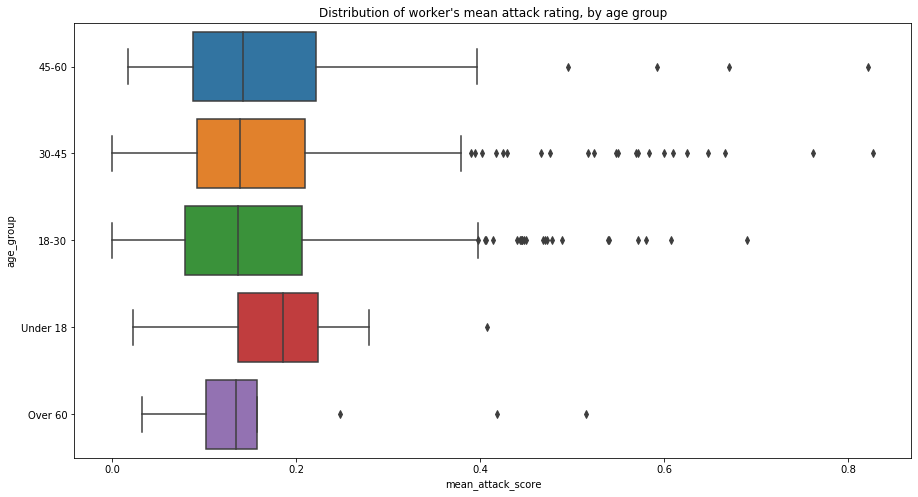

In [31]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("Distribution of worker's mean attack rating, by age group")
sns.boxplot(x="mean_attack_score", y="age_group", data=att_demographic, ax=ax )
plt.savefig("images/age_box.png")

### Implications 

A very similar skew is also present in the toxicity dataset


1. <b> Which, if any, of these demo applications would you expect the Perspective API to perform poorly in? Why? </b>

    The API would not work very well for social media platforms with a much younger user base (teenagers and pre-teens). There is not much representation of this age group in the labeling sample and what this group considers toxic/personal attack may not be correctly represented in the dataset as can be seen from the boxplot above. Teenagers use different lingo that constantly keeps changing and this is not captured in the dataset.


2. <b>What are some kinds of hostile speech that would be difficult to accurately detect using the approach used to train the Perspective API models? </b>

    Speech keeps evolving with time. A lot of bad words and slang are different every few years. This particular dataset did not have many labellers under the age of 18 but a lot of the use cases of perspective API are applied to sites like facebook and youtube that have a large teenage user base as well. This dataset may not flag some of the new words/slang used by the younger generation and thereby creating a hostile environment for young impressionable minds.


3. <b> Imagine you are one of the Google data scientists who maintains the Perspective API. If you wanted to improve the model or the API itself to make it work better for any of these purposes, how should they go about doing that? </b>

    One way to improve the model would be to create more training annotated data using a more representative sample of the population who is using the applications (teenagers for example). Platforms like crowdsourcing can help in this regard. Another definite way to improve the model would be get user feedback and apply the corrections to periodically update the model. I think Google is already using feedback to understand if a comment is wrongly being labeled as toxic. Also NLP applications work best when they are domain specific. The data is trained on wikipedia comments which possess a very different type of makeup and usage compared to youtube comments. If feasible, data should be tuned to the required application as well.

## Analysis 2: Are certain labels more prone to class imbalance (toxicity dataset)?

Class imbalance can lead to over or under representation of certain labels leading to a bias/skew.

In [26]:
## read in the files for personal attack dataset
tox_comments = pd.read_csv('data/toxicity_annotated_comments.tsv', sep = '\t', index_col = 0)
tox_annotations = pd.read_csv('data/toxicity_annotations.tsv',  sep = '\t')
tox_demographic = pd.read_csv('data/toxicity_worker_demographics.tsv',  sep = '\t')

## remove new line and tab tokens
tox_comments['comment'] = tox_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
tox_comments['comment'] = tox_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

#create merged dataset for later use
toxic_df = tox_annotations.merge(tox_comments, on = 'rev_id')

Inspired by the analysis on certain communites or names [2]. Function that takes in a dataframe, subsets it based on a keyword and returns the class balance of toxic to all available comments.

In [27]:
def class_balance(frame, keyword):
    """Returns the fraction of the dataset with a particular keyword labeled toxic."""
    if keyword:
        frame = frame[frame['comment'].str.contains(keyword, case=False)]
    return len(frame.query('toxic')) / len(frame)

In [28]:
toxic_comments = tox_comments.copy() 
#threshold of 50% is used to consider a comment as toxic
toxic_comments['toxic'] = tox_annotations.groupby('rev_id')['toxicity'].mean() > 0.5

print('overall fraction of comments labeled toxic:', class_balance(toxic_comments,keyword=None))

overall fraction of comments labeled toxic: 0.09620129504151897


In [29]:
TEST_TERMS = ['tall', 'wikipedia', 'teacher', 'Mexican',
              'lesbian', 'gay', 'bisexual', 'transgender', 'queer',
              'homosexual', 'heterosexual', 'muslim', 'jew', 
              'christian','feminist', 'black', 'white']

print('overall class balance        {:.1f}%\t{} examples'.format(
    100 * class_balance(toxic_comments, keyword=None), len(toxic_comments)))

for fraction, num, term in sorted((class_balance(toxic_comments, term),
                                   len(toxic_comments[toxic_comments['comment'].str.contains(term, case=False)]),
                                   term)
                                  for term in TEST_TERMS):
    print('class balance for {:10s} {:.1f}%\t{} examples'.format(term, 100 * fraction, num))

overall class balance        9.6%	159686 examples
class balance for bisexual   4.8%	42 examples
class balance for christian  6.7%	1178 examples
class balance for heterosexual 7.0%	43 examples
class balance for tall       7.0%	2369 examples
class balance for wikipedia  7.2%	27947 examples
class balance for teacher    9.7%	300 examples
class balance for muslim     10.4%	747 examples
class balance for feminist   11.4%	79 examples
class balance for white      11.9%	1516 examples
class balance for black      12.2%	1479 examples
class balance for jew        16.2%	1524 examples
class balance for transgender 18.8%	32 examples
class balance for Mexican    22.4%	143 examples
class balance for lesbian    30.0%	80 examples
class balance for homosexual 38.5%	366 examples
class balance for gay        54.6%	1005 examples
class balance for queer      62.4%	93 examples


<b> It can be seen that some terms that people identify with are more imbalanced in their toxicity distribution (maybe  because people use these terms more often as insults). However, this can potentially cause a model based on this data to learn terms like 'gay, queer' to be factors contributing to toxicity and thereby prevent healthy discussions or comments by/about these communities. This will marginalize the community more as can be seen in https://www.engadget.com/2017-09-01-google-perspective-comment-ranking-system.html</b>.

Let us train a model on this data and see if this is true..

In [30]:
toxic_comments['comment'] = toxic_comments['comment'].str.lower()
#split into classes specified in data file
train_tox_comments = toxic_comments.query("split=='train'") 
test_tox_comments = toxic_comments.query("split=='test'")

#classification pipeline 
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))), # 1 and 2 word combinations are used
    ('tfidf', TfidfTransformer(norm = 'l2')), 
    ('clf', LogisticRegression()),
])
clf = clf.fit(train_tox_comments['comment'], train_tox_comments['toxic']) #fit the model on the training set
auc = roc_auc_score(test_tox_comments['toxic'], clf.predict_proba(test_tox_comments['comment'])[:, 1]) #test auc on test set
print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.963


<b> We can use our model to predict what some examples return as the predicted label. (toxicity threshold is 0.5)</b> 

In [31]:
sent = "I am proud to be gay."
print(f'"{sent}" is labelled {clf.predict([sent])[0]} for toxicity with a probability of {clf.predict_proba([sent])[0][1]}')

"I am proud to be gay." is labelled True for toxicity with a probability of 0.7675566130142711


In [32]:
sent = 'You should attend the gay pride marathon.'
print(f'"{sent}" is labelled {clf.predict([sent])[0]} for toxicity with a probability of {clf.predict_proba([sent])[0][1]}')

"You should attend the gay pride marathon." is labelled True for toxicity with a probability of 0.7052613379210002


In [33]:
sent = "I am proud to be a woman."
print(f'"{sent}" is labelled {clf.predict([sent])[0]} for toxicity with a probability of {clf.predict_proba([sent])[0][1]}')

"I am proud to be a woman." is labelled False for toxicity with a probability of 0.12653890399512827


<b> Benign statements like above are learnt as toxic and could potentially be silenced/censored and take the voice away from minority communities.

### Implications 

1. <b>What are some kinds of hostile speech that would be difficult to accurately detect using the approach used to train the Perspective API models? </b>

    Hostile speech about certain minority communities (LGBTQ, jews, muslims, black) is very imbalanced in the dataset and would be flagged as hostile/toxic even when someone is carrying out a healthy discussion or just mentioning facts about a topic. As can be seen this has already had negative consequences in using the API to rate the toxicity of a statement as can be seen in https://www.engadget.com/2017-09-01-google-perspective-comment-ranking-system.html.


2. <b> What are some other contexts or applications where you would expect the Perspective API to perform particularly well, or particularly poorly? Why? </b>

    Let's say the perspective API is extended to be used to monitor and keep a check of toxicity in a dating app. This model can censor healthy discussions about certain groups and prevent them from sharing information about themselves with each other. This dataset also does not capture the nuances of what can be toxic on a dating app (stalking, pressured requests, unsolicited images) and will not be perform will for such a use case.
    
    
3. <b> Imagine you are one of the Google data scientists who maintains the Perspective API. If you wanted to improve the model or the API itself to make it work better for any of these purposes, how should they go about doing that? </b>

    One way to improve the model would be get user feedback to identify wrongly identified toxic comments and apply the corrections to periodically update the model. I think Google is already using feedback to understand if a comment is wrongly being labeled as toxic. 

# Further exploration
## Time trend

Is there a time trend in the balance of toxic comments for certain words 

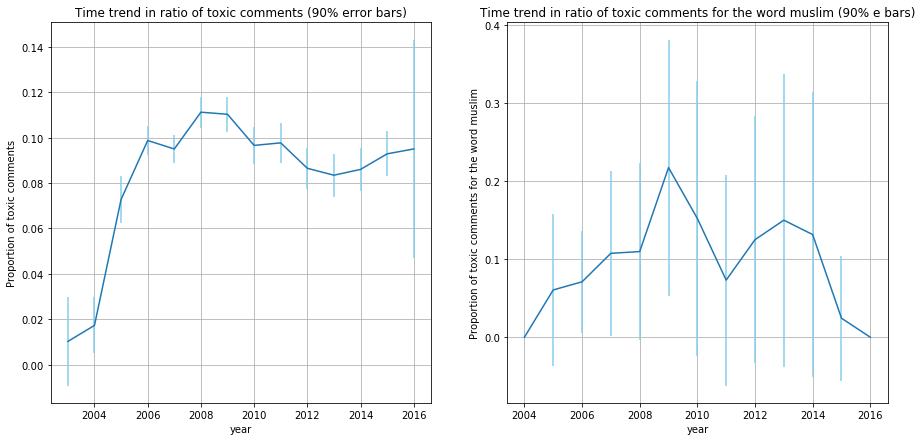

In [70]:
time_df = toxic_comments[['year','toxic']].groupby('year',as_index=False).agg(["mean", "sem"]).reset_index()
time_df = time_df[time_df.year > 2002]

#trend in toxicity for comments containing the word muslim 
comm_comments = toxic_comments[toxic_comments['comment'].str.contains('muslim', case=False)]
time_df1 = comm_comments[['year','toxic']].groupby('year',as_index=False).agg(["mean", "sem"]).reset_index()
time_df1 = time_df1[time_df1.year > 2002]

#plot the time series
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

ax1.errorbar(time_df['year'],time_df['toxic']['mean'],yerr = time_df['toxic']['sem']*2*1.64, ecolor='skyblue')
ax1.set_ylabel('Proportion of toxic comments')
ax1.set_xlabel('year')
ax1.set_title('Time trend in ratio of toxic comments (90% error bars)')
ax1.grid()

ax2.errorbar(time_df1['year'],time_df1['toxic']['mean'],yerr = time_df1['toxic']['sem']*2*1.64, ecolor='skyblue') 
ax2.set_xlabel('year')
ax2.set_ylabel('Proportion of toxic comments for the word muslim')
ax2.set_title('Time trend in ratio of toxic comments for the word muslim (90% e bars)')
ax2.grid()
plt.savefig('images/time_trend.png') #save to file

The right plot shows a rise in the proportion of toxic comments for the word muslim between 2008-2009

### Try it yourself, enter a word and view the trend

In [ ]:
word = input('Enter a word to check toxicity for:')

comm_comments = toxic_comments[toxic_comments['comment'].str.contains(word, case=False)]
time_df1 = comm_comments[['year','toxic']].groupby('year',as_index=False).agg(["mean", "sem"]).reset_index()
time_df1 = time_df1[time_df1.year > 2003]

plt.errorbar(time_df1['year'],time_df1['toxic']['mean'],yerr = time_df1['toxic']['sem']*2*1.64, ecolor='skyblue') 
plt.xlabel('year')
plt.ylabel(f'Proportion of toxic comments for the word {word}')
plt.title('Time trend in ratio of toxic comments (90% error bars)')
plt.grid()

## Most common flagged words
### Word cloud visualizations of the most common toxic words in the two datasets

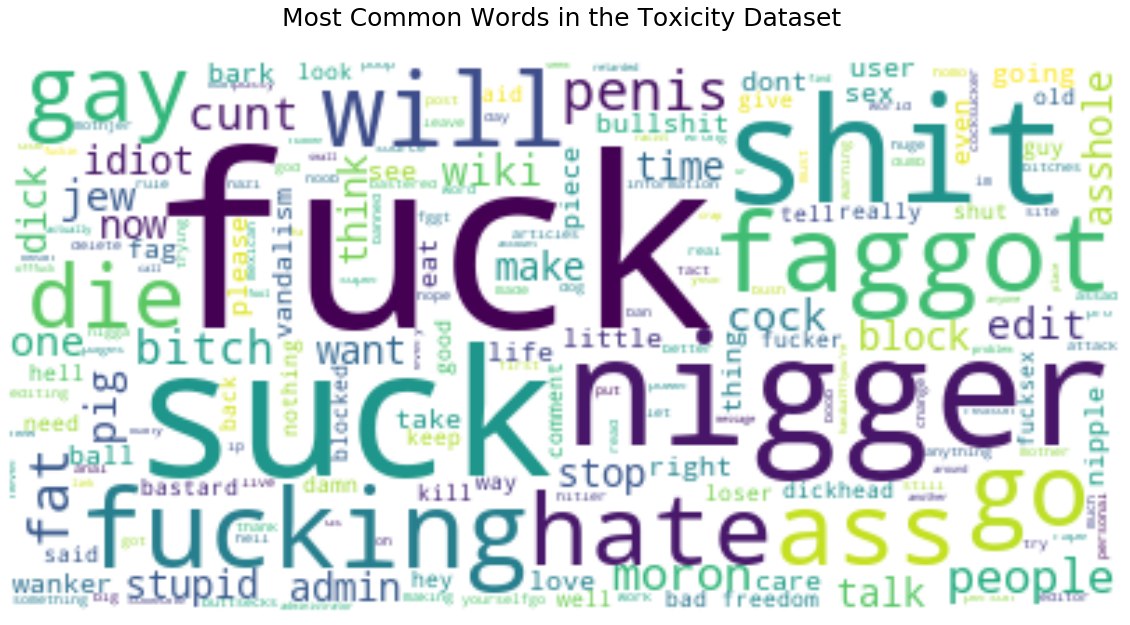

In [19]:
df = toxic_comments[toxic_comments.toxic==True].copy() 
df['comment']= df['comment'].str.lower()
all_df = df['comment'].str.split(' ')

all_df_cleaned = []

for text in all_df:
    text = [x.strip(string.punctuation) for x in text]
    all_df_cleaned.append(text)

text_df = [" ".join(text) for text in all_df_cleaned]
final_text_df = " ".join(text_df)

stopwords = set(STOPWORDS)
stopwords.update(["know","article","say","come","page","wikipedia",'hi'])

wordcloud_df = WordCloud(stopwords=stopwords,background_color="white",collocations = False).generate(final_text_df)

plt.figure(figsize = (20,20))
plt.imshow(wordcloud_df, interpolation='bilinear')
plt.title('Most Common Words in the Toxicity Dataset \n',fontdict = {'fontsize' : 25})
plt.axis("off")
plt.savefig('images/toxic_wc1.png') #save to file
plt.show()


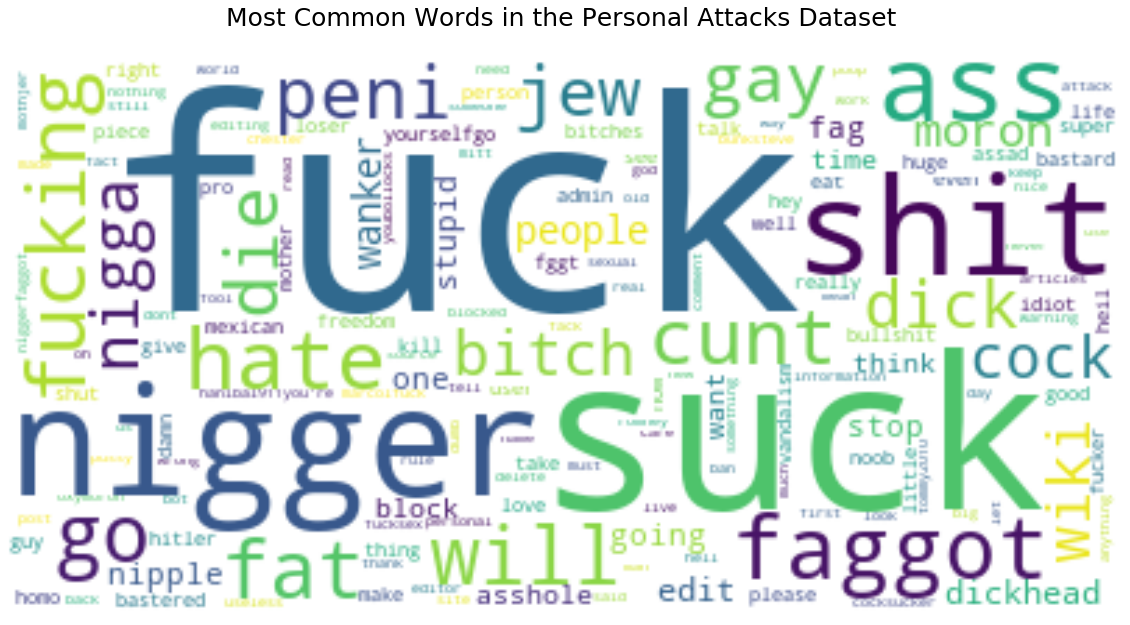

In [25]:
att_comments['attack'] = att_annotations.groupby('rev_id')['attack'].mean() > 0.5

df = att_comments[att_comments.attack==True].copy() 
df['comment']= df['comment'].str.lower()
all_df = df['comment'].str.split(' ')

all_df_cleaned = []

for text in all_df:
    text = [x.strip(string.punctuation) for x in text]
    all_df_cleaned.append(text)

text_df = [" ".join(text) for text in all_df_cleaned]
final_text_df = " ".join(text_df)

stopwords = set(STOPWORDS)
stopwords.update(["know","article","say","come","page","wikipedia",'hi'])

wordcloud_df = WordCloud(stopwords=stopwords,background_color="white",collocations = False).generate(final_text_df)

plt.figure(figsize = (20,20))
plt.imshow(wordcloud_df, interpolation='bilinear')
plt.title('Most Common Words in the Personal Attacks Dataset \n',fontdict = {'fontsize' : 25})
plt.axis("off")
plt.savefig('images/pa_wc1.png') #save to file
plt.show()

## References

[1] https://www.census.gov/popclock/ <br>
[2] https://github.com/conversationai/unintended-ml-bias-analysis/blob/master/unintended_ml_bias/Dataset_bias_analysis.ipynb